---
# Data Collection
---

In [ ]:
# These values can be changed to the requested ticker and parameters 

ticker = 'GS'
from_date = '2010-01-01'
to_date = '2018-12-31'
type = 'line'


In [ ]:
from urllib.request import urlopen
import json

# Get JSON data from the requested url
def get_json_data(url):
    response = urlopen(url)
    response = response.read().decode("utf-8")
    return json.loads(response)

# Conver the provided parameters into FMP url
def get_url(ticker, from_date = None, to_date = None, type = None):
    url = "https://financialmodelingprep.com/api/v3/historical-price-full/" + ticker + "?"
    
    if from_date != None:
        url += 'from=' + from_date + "&"
    if to_date != None:
        url += 'to=' + to_date + '&'
    if type != None:
        url += 'serietype=' + type + '&'

    return url[:-1]

json_data = get_json_data(get_url(ticker, from_date, to_date, type))


In [ ]:
import csv

# Write JSON data to csv file
outputWriter = csv.writer(open('dataset.csv', 'w'), delimiter=',')

outputWriter.writerow(['date', ticker])
for obj in json_data['historical']:
    outputWriter.writerow([obj['date'] , obj['close']])

---
# Data Preprocessing
---



In [ ]:
# Supposedly all imports

# from utils import *

import time
import numpy as np

import pandas as pd

# from mxnet import nd, autograd, gluon
# from mxnet.gluon import nn, rnn
# import mxnet as mx
import datetime
# import seaborn as sns

import matplotlib.pyplot as plt
# %matplotlib inline
# from sklearn.decomposition import PCA

# import math

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler

# import xgboost as xgb
# from sklearn.metrics import accuracy_score


In [ ]:
import warnings
warnings.filterwarnings("ignore")


There are 2177 number of days in the dataset.
Number of training days: 1523. Number of test days: 654.


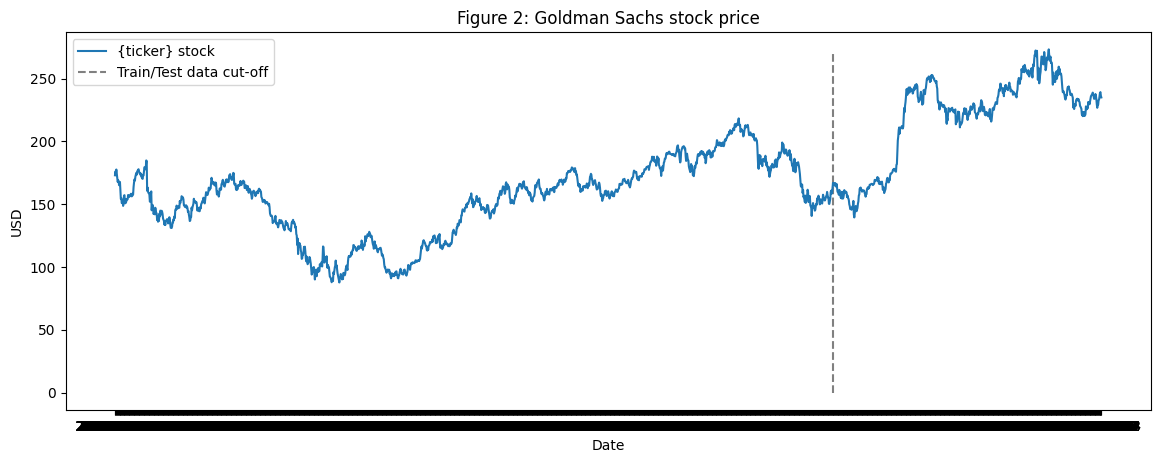

In [53]:

complete_dataset = pd.read_csv('dataset.csv')
total_days = complete_dataset.shape[0]
num_training_days = int(total_days * .7)
num_testing_days = total_days-num_training_days
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, num_testing_days))

# Print timeseries of {ticker}

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(complete_dataset['date'], complete_dataset[ticker], label='{ticker} stock')
plt.vlines(str(datetime.date(2016, 4, 20)), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

## Correlated Assets

### Similar Companies or Competitors

### Global Economic Indices

### Volatility Index

### Composite Indices (S&P500, DOW, NASDAQ, BSE Sensex, FTSE100, Nikkei225)

### Currencies

### Earnings Reports and Growth?